Currently looking at only the Cattle dataset as the Pig and Sheep dataset require additional data cleaning, as columns signifincalty change over the years.

In [40]:
import pandas as pd
import numpy as np

pd.set_option('display.float_format', lambda x: '%.2f' % x)

df = pd.read_excel('Cattle Consolidated.xlsx')
pd.to_datetime(df.Year, format='%Y')

# df.head()
df.describe()

,Year,Bulls (>1 yr.),Dairy cows,Dairy heifers (>1 yr.),Beef cows,Beef heifers for breeding (>1 yr.),Beef heifers for slaughter (>1 yr.),Steers (>1 yr.),Calves (<1 yr.),Total cattle
count,864.00,864.00,864.00,864.00,864.00,864.00,864.00,864.00,864.00,864.00
mean,2012.50,432.44,6739.28,3914.38,6030.81,909.93,3854.14,5650.80,10057.71,37636.10
std,5.19,419.66,8538.55,4761.51,6260.70,965.66,7544.11,11162.82,10422.04,40340.96
min,2004.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2008.00,129.93,788.01,450.00,1600.00,206.98,379.54,222.19,2345.31,9021.06
50%,2012.50,341.83,3581.50,2044.94,3996.67,640.90,1156.50,1317.11,6676.85,23717.49
75%,2017.00,594.53,8341.64,5256.50,8400.50,1304.99,3628.16,4126.77,12779.38,46060.14
max,2021.00,4605.00,37700.00,31016.00,36400.00,5800.00,71200.00,61308.00,50800.00,194050.00


Data from 2009 and 2010 Beef heifers for breeding (>1 yr.) and Steers (>1 yr.) were left blank, for the time being 0 was placed. All confidentional numbers were also replaced with 0 to avoid NAs

<AxesSubplot:>

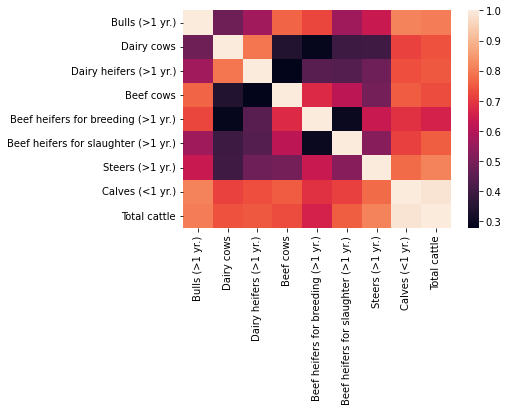

In [37]:
import seaborn as sns
# Remove first column from dataframe for correlation analysis
dfcorr = df.iloc[:, 1:]
corr = dfcorr.corr()
sns.heatmap(corr)


<AxesSubplot:xlabel='Year'>

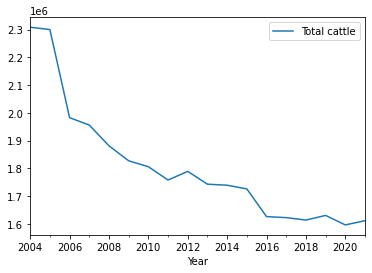

In [18]:
# Pivots dataframe by year and sum of total cattle
pvt_yr = pd.pivot_table(df, index=['Year'], values=['Total cattle'], aggfunc='sum')

# Convert Year to datetime
pvt_yr.index = pd.to_datetime(pvt_yr.index, format='%Y')

# Plot pvt_yr
pvt_yr.plot()

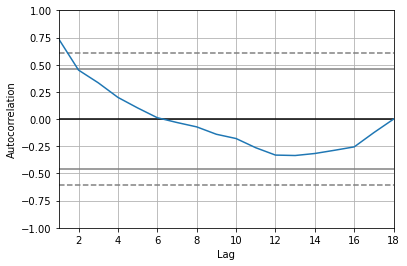

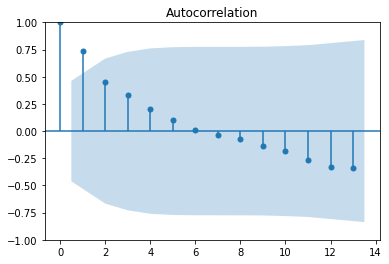

In [24]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import pyplot as plt

autocorrelation_plot(pvt_yr)
plot_acf(pvt_yr)
plt.show()

                               SARIMAX Results                                
Dep. Variable:           Total cattle   No. Observations:                   18
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -232.413
Date:                Mon, 06 Jun 2022   AIC                            472.827
Time:                        17:16:05   BIC                            476.388
Sample:                    01-01-2004   HQIC                           473.318
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.807e+06   3.22e+05      5.615      0.000    1.18e+06    2.44e+06
ar.L1          1.1289      0.398      2.833      0.005       0.348       1.910
ar.L2         -0.1634      0.384     -0.425      0.6

c:\Users\navee\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\navee\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\navee\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


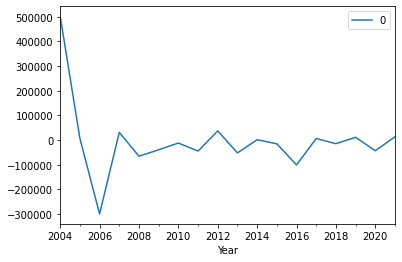

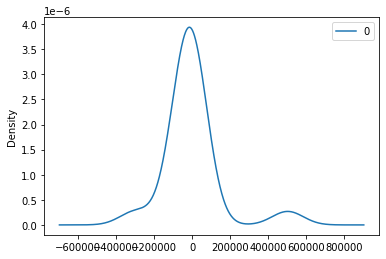

               0
count      18.00
mean    -4133.78
std    146842.58
min   -298992.14
25%    -44026.70
50%    -13156.76
75%     10250.88
max    501767.22


In [41]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(pvt_yr, order=(2, 0, 0))
model_fit = model.fit()
print(model_fit.summary())

# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

# density plot of residuals
residuals.plot(kind='kde')
plt.show()

# summary of residuals
print(residuals.describe())
